In [45]:
# Import the necessary modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

# Specify the file path of your CSV file
file_path = "data/AZWatch_subscribers.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Separate predictor variables from class label
X = df.drop(['subscriber_id','subscription_status'], axis=1)
y = df.subscription_status

# Split intro training and test sets (20% test)
X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=.2, random_state=42)

In [46]:
df.info()
df.head()
#df['age_group'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subscriber_id         1000 non-null   int64  
 1   age_group             1000 non-null   object 
 2   engagement_time       1000 non-null   float64
 3   engagement_frequency  1000 non-null   int64  
 4   subscription_status   1000 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB


,subscriber_id,age_group,engagement_time,engagement_frequency,subscription_status
0,14451,18-34,5.55,7,subscribed
1,18386,under 18,5.12,12,subscribed
2,12305,35 and over,4.25,4,churned
3,17546,18-34,8.54,15,subscribed
4,15399,18-34,12.12,20,subscribed


In [47]:
# Use get_dummies to encode 'age_group' in both training and test sets
X_train_encoded = pd.get_dummies(X_train, columns=['age_group'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['age_group'], drop_first=True)

# Ensure both train and test have the same columns after encoding
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

X_train_encoded.head(), X_test_encoded.head()

(     engagement_time  ...  age_group_under 18
 29              5.00  ...                   0
 535             2.77  ...                   0
 695             4.67  ...                   0
 557             6.97  ...                   1
 836             6.88  ...                   0
 
 [5 rows x 4 columns],
      engagement_time  ...  age_group_under 18
 521             4.72  ...                   0
 737             8.67  ...                   0
 740             6.60  ...                   0
 660             5.23  ...                   0
 411             7.91  ...                   1
 
 [5 rows x 4 columns])

In [48]:
# Instantiate the models
model1 = LogisticRegression(max_iter=1000, random_state=42)
model2 = DecisionTreeClassifier(random_state=42)
model3 = RandomForestClassifier(random_state=42)

# Train the models on the training set
model1.fit(X_train_encoded, y_train)
model2.fit(X_train_encoded, y_train)
model3.fit(X_train_encoded, y_train)

RandomForestClassifier(random_state=42)

In [49]:
# Evaluate and compare model performance with different configurations

# 1. Baseline: previously trained models
score_logreg = model1.score(X_test_encoded, y_test)
score_dtree = model2.score(X_test_encoded, y_test)
score_rf = model3.score(X_test_encoded, y_test)

# 2. Decision Tree with 'entropy' criterion and max_depth=3
dtree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
dtree_entropy.fit(X_train_encoded, y_train)
score_dtree_entropy = dtree_entropy.score(X_test_encoded, y_test)

# 3. Decision Tree with 'gini' criterion and max_depth=5
dtree_gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
dtree_gini.fit(X_train_encoded, y_train)
score_dtree_gini = dtree_gini.score(X_test_encoded, y_test)

# 4. Random Forest with max_depth=3
rf_depth3 = RandomForestClassifier(max_depth=3, random_state=42)
rf_depth3.fit(X_train_encoded, y_train)
score_rf_depth3 = rf_depth3.score(X_test_encoded, y_test)

# 5. Random Forest with max_depth=7
rf_depth7 = RandomForestClassifier(max_depth=7, random_state=42)
rf_depth7.fit(X_train_encoded, y_train)
score_rf_depth7 = rf_depth7.score(X_test_encoded, y_test)

# Collect results in a dictionary for easy comparison
model_scores = {
    "Logistic Regression": score_logreg,
    "Decision Tree (default)": score_dtree,
    "Random Forest (default)": score_rf,
    "Decision Tree (entropy, max_depth=3)": score_dtree_entropy,
    "Decision Tree (gini, max_depth=5)": score_dtree_gini,
    "Random Forest (max_depth=3)": score_rf_depth3,
    "Random Forest (max_depth=7)": score_rf_depth7
}

model_scores

{'Logistic Regression': 0.92,
 'Decision Tree (default)': 0.875,
 'Random Forest (default)': 0.88,
 'Decision Tree (entropy, max_depth=3)': 0.905,
 'Decision Tree (gini, max_depth=5)': 0.92,
 'Random Forest (max_depth=3)': 0.915,
 'Random Forest (max_depth=7)': 0.925}

In [50]:
score = model1.score(X_test_encoded, y_test)
print(score)

0.92


In [51]:
from sklearn.preprocessing import StandardScaler

# Remove unwanted columns from X and save as segmentation
# Assuming we want to keep only numerical columns for clustering
segmentation = X.drop(columns=['age_group'])

# Normalize the data using StandardScaler
scaler = StandardScaler()
segmentation_scaled = scaler.fit_transform(segmentation)

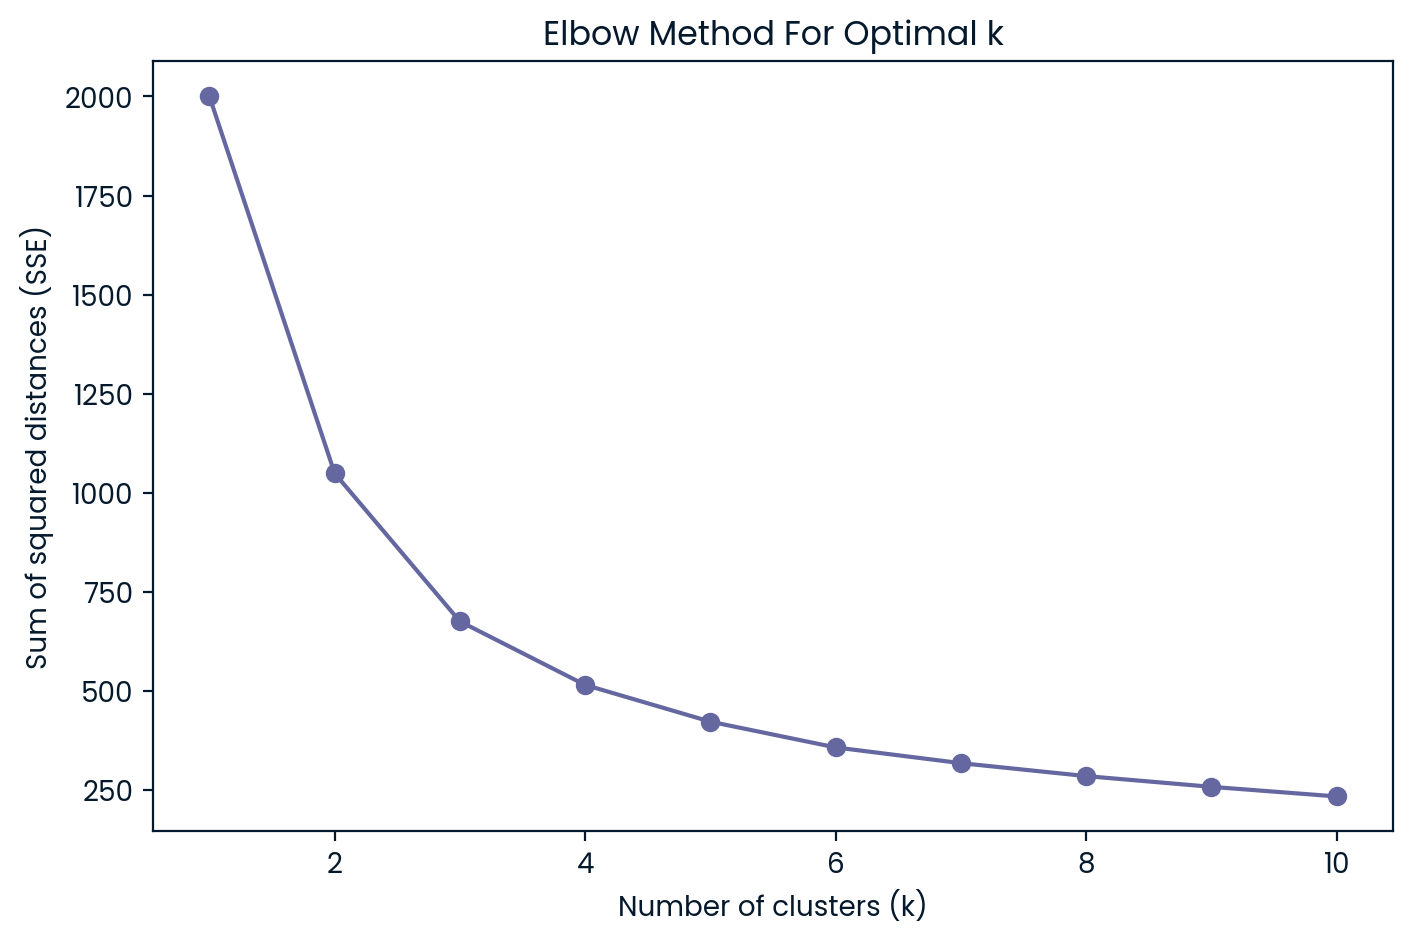

In [52]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Elbow method to determine optimal k
sse = {}
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(segmentation_scaled)
    sse[k] = kmeans.inertia_

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of squared distances (SSE)")
plt.title("Elbow Method For Optimal k")
plt.show()

# Based on the elbow plot, choose k (for example, k=3)
optimal_k = 3  # Change this value after inspecting the plot

# Fit KMeans with the chosen k and assign cluster labels
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
segmentation['cluster_id'] = kmeans.fit_predict(segmentation_scaled)

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select only numerical features from X
numerical_features = ['engagement_time', 'engagement_frequency']
X_numerical = X[numerical_features]

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Apply KMeans clustering (choose k=3 as a default, can be adjusted)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
X_clustered = X_numerical.copy()
X_clustered['cluster_id'] = cluster_labels

# Analyze average values by cluster_id and round to nearest whole number
analysis = X_clustered.groupby('cluster_id')[numerical_features].mean().round(0)

In [54]:
analysis

,engagement_time,engagement_frequency
cluster_id,,
0,9.0,9.0
1,4.0,5.0
2,7.0,18.0
